In [1]:
setwd("..")

In [2]:
source("Source/functions.R")

In [3]:
library("data.table")
library("Matrix")
library("pheatmap")
library("DESeq2")
library("dendextend")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:Matrix’:

    expand, unname

The following objects are masked from ‘package:data.table’:

    first, second

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    e

In [4]:
SampleInfo <- fread("Data/SampleInfo.csv")

sampleIDs <- SampleInfo[, SampleID]
SampleInfo[, Type := factor(SampleInfo[, Type], levels = c("N", "S", "M", "T"))]
SampleInfo[, IsResponsive := factor(ifelse(SampleInfo[, Type] == "N", "N", "Y"), levels = c("N", "Y"))]

sampleGroups <- c("N", "S", "M", "T")

groupColors <- c(N = "#888888", 
                 S = rgb(red = 0, green = 128/255, blue = 225/255),
                 M = rgb(red = 255/255, green = 255/255, blue = 0), 
                 T = rgb(red = 255/255, green = 0, blue = 255/255)
)

sampleColors <- groupColors[SampleInfo[J(sampleIDs), as.character(Type), on = "SampleID"]]
names(sampleColors) <- sampleIDs

In [5]:
cnts_exon <- as.matrix(read.csv("Data/cnts_exon.csv.gz", row.names = 1, check.names = FALSE))
pairwise_cmps <- c("T_vs_S", "T_vs_M", "S_vs_M", "S_vs_N", "M_vs_N", "T_vs_N")
pairwise_siggenes_exon <- Tools$read_xlsx(file = "Result/pairwise_siggenes_exon.xlsx", sheet = pairwise_cmps)
pairwise_siggenes_exon <- lapply(pairwise_siggenes_exon, function(X) lapply(X, function(x) Tools$omit_space(x)))

In [6]:
Vanlandewijck2018_astro_cnts_dt <- fread("Data/Vanlandewijck2018/GSE99058_cnts.csv.gz")
Vanlandewijck2018_astro_metadata <- fread("Data/Vanlandewijck2018/GSE99058_metadata.csv")
Vanlandewijck2018_astro_cnts <- Matrix(
    as.matrix(Vanlandewijck2018_astro_cnts_dt[, -1]), 
    dimnames = list(Vanlandewijck2018_astro_cnts_dt[[1]], names(Vanlandewijck2018_astro_cnts_dt)[-1])
)

In [7]:
Erickson2019_cnts_dt <- fread("Data/Erickson2019/GSE92457_cnts.csv.gz")
Erickson2019_cnts <- as.matrix(Erickson2019_cnts_dt[, -1])
rownames(Erickson2019_cnts) <- Erickson2019_cnts_dt[[1]]

In [8]:
Erickson2019_metadata <- fread("Data/Erickson2019/GSE92457_metadata.csv.gz")
Erickson2019_metadata[, table(characteristics_ch1.3, characteristics_ch1.4)]

                            characteristics_ch1.4
characteristics_ch1.3        cell type: astrocyte cell type: total homogenate
  treatment: Control (water)                   10                          12
  treatment: Ethanol                           10                          12

In [9]:
Erickson2019_metadata_astro_water <- Erickson2019_metadata[characteristics_ch1.4 == "cell type: astrocyte" & characteristics_ch1.3 == "treatment: Control (water)"]
Erickson2019_metadata_astro_ethanol <- Erickson2019_metadata[characteristics_ch1.4 == "cell type: astrocyte" & characteristics_ch1.3 == "treatment: Ethanol"]

Erickson2019_metadata_astro <- rbind(Erickson2019_metadata_astro_water, Erickson2019_metadata_astro_ethanol)
Erickson2019_metadata_astro_sampleIDs <- Erickson2019_metadata_astro[, `geo_accession`]
Erickson2019_astro_cnts <- Erickson2019_cnts[, Erickson2019_metadata_astro_sampleIDs]
dim(Erickson2019_astro_cnts)

[1] 24426    20

In [10]:
Batiuk2020_cnts_dt <- fread("Data/Batiuk2020/GSE114000_cnts.csv.gz")
Batiuk2020_metadata <- fread("Data/Batiuk2020/GSE114000_metadata.csv")
Batiuk2020_cnts <- Matrix(as.matrix(Batiuk2020_cnts_dt[, -1]), dimnames = list(Batiuk2020_cnts_dt[[1]], names(Batiuk2020_cnts_dt)[-1]))
Batiuk2020_astro_cnts <- Batiuk2020_cnts[, Batiuk2020_metadata[grepl("^AST", Type), `Cell ID`]]
dim(Batiuk2020_astro_cnts)

[1] 49660  1811

In [11]:
Zeisel2015_cnts_dt <- fread("Data/Zeisel2015/linnarssonlab.org/cnts_exon.csv.gz")

In [12]:
Zeisel2015_cnts <- Matrix(
    as.matrix(Zeisel2015_cnts_dt[, -1]), 
    dimnames = list(Zeisel2015_cnts_dt[[1]], names(Zeisel2015_cnts_dt)[-1])
)

dim(Zeisel2015_cnts)

[1] 19972  3005

In [13]:
Zeisel2015_metadata <- fread("Data/Zeisel2015/linnarssonlab.org/metadata.csv.gz")
Zeisel2015_astro_metadata_astro1 <- Zeisel2015_metadata[level2class == "Astro1"]
Zeisel2015_astro_metadata_astro2 <- Zeisel2015_metadata[level2class == "Astro2"]
Zeisel2015_astro_metadata <- rbind(Zeisel2015_astro_metadata_astro1, Zeisel2015_astro_metadata_astro2)
Zeisel2015_astro_metadata[, table(level1class, level2class)]

                      level2class
level1class            Astro1 Astro2
  astrocytes_ependymal     68     61

In [14]:
Zeisel2015_astro_cellIDs <- Zeisel2015_astro_metadata[, cell_id]
Zeisel2015_astro_cnts <- Zeisel2015_cnts[, Zeisel2015_astro_cellIDs]
dim(Zeisel2015_astro_cnts)

[1] 19972   129

In [15]:
totcnts <- list(
    ThisStudy = colSums(cnts_exon, na.rm = TRUE), 
    Zeisel2015 = colSums(Zeisel2015_astro_cnts, na.rm = TRUE), 
    Vanlandewijck2018 = colSums(Vanlandewijck2018_astro_cnts, na.rm = TRUE), 
    Batiuk2020 = colSums(Batiuk2020_astro_cnts, na.rm = TRUE), 
    Erickson2019 = colSums(Erickson2019_astro_cnts, na.rm = TRUE)
)

totgenes <- list(
    ThisStudy = colSums(cnts_exon > 0, na.rm = TRUE), 
    Zeisel2015 = colSums(Zeisel2015_astro_cnts > 0, na.rm = TRUE), 
    Vanlandewijck2018 = colSums(Vanlandewijck2018_astro_cnts > 0, na.rm = TRUE), 
    Batiuk2020 = colSums(Batiuk2020_astro_cnts > 0, na.rm = TRUE), 
    Erickson2019 = colSums(Erickson2019_astro_cnts > 0, na.rm = TRUE)
)

### Fig. S3A

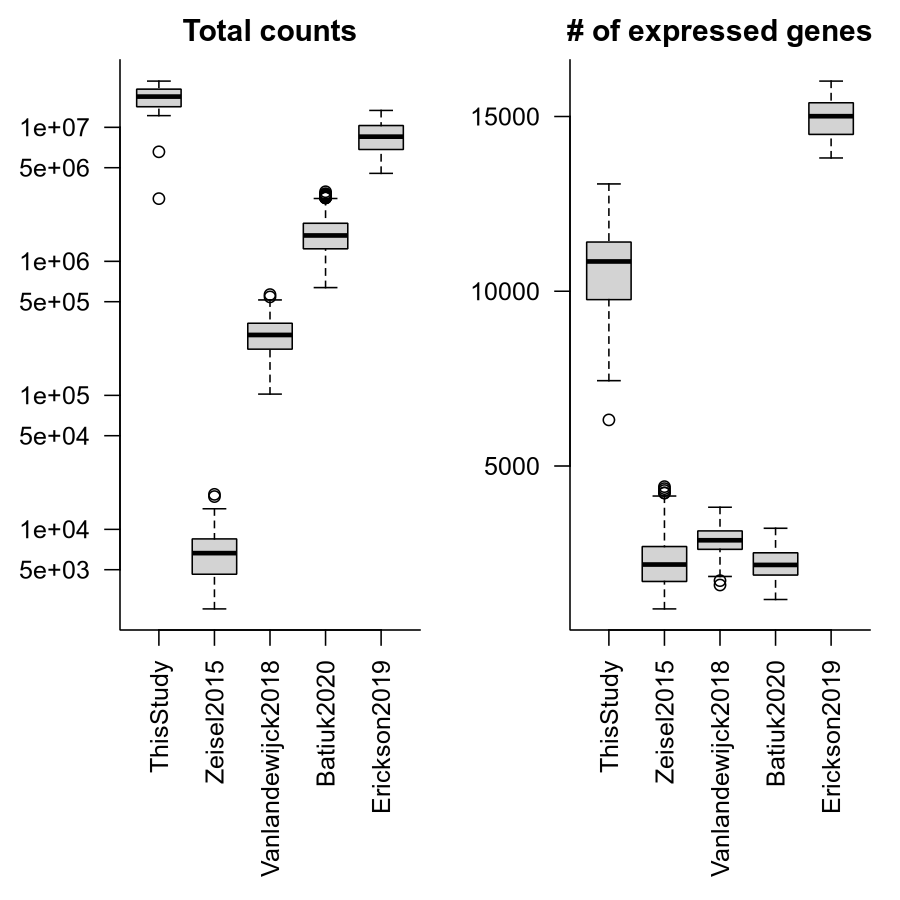

In [16]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
par(ps = 12, mar = c(9, 4, 2, 1), bty = "l", lend = 2, ljoin = 2, mfrow = c(1, 2))
boxplot(totcnts, log = "y", las = 2, xlab = "", ylab = "", main = "Total counts")
boxplot(totgenes, las = 2, xlab = "", ylab = "", main = "# of expressed genes")

In [17]:
cnts_exon_T_vs_S_both <- cnts_exon[match(pairwise_siggenes_exon$T_vs_S$both, rownames(cnts_exon)), ]
Zeisel2015_astro_cnts_T_vs_S_both <- as.data.frame(as.matrix(Zeisel2015_astro_cnts))[(match(pairwise_siggenes_exon$T_vs_S$both, rownames(Zeisel2015_astro_cnts))), ]
Vanlandewijck2018_astro_cnts_T_vs_S_both <- as.data.frame(as.matrix(Vanlandewijck2018_astro_cnts))[(match(pairwise_siggenes_exon$T_vs_S$both, rownames(Vanlandewijck2018_astro_cnts))), ]
Batiuk2020_astro_cnts_T_vs_S_both <- as.data.frame(as.matrix(Batiuk2020_astro_cnts))[(match(pairwise_siggenes_exon$T_vs_S$both, rownames(Batiuk2020_astro_cnts))), ]
Erickson2019_astro_cnts_T_vs_S_both <- Erickson2019_astro_cnts[(match(pairwise_siggenes_exon$T_vs_S$both, rownames(Erickson2019_astro_cnts))), ]

fraccells_T_vs_S_both <- cbind(
    ThisStudy = rowMeans(cnts_exon_T_vs_S_both > 0), 
    Zeisel2015 = rowMeans(Zeisel2015_astro_cnts_T_vs_S_both > 0), 
    Vanlandewijck2018 = rowMeans(Vanlandewijck2018_astro_cnts_T_vs_S_both > 0), 
    Batiuk2020 = rowMeans(Batiuk2020_astro_cnts_T_vs_S_both > 0), 
    Erickson2019 = rowMeans(Erickson2019_astro_cnts_T_vs_S_both > 0)
)

### Fig. S3B

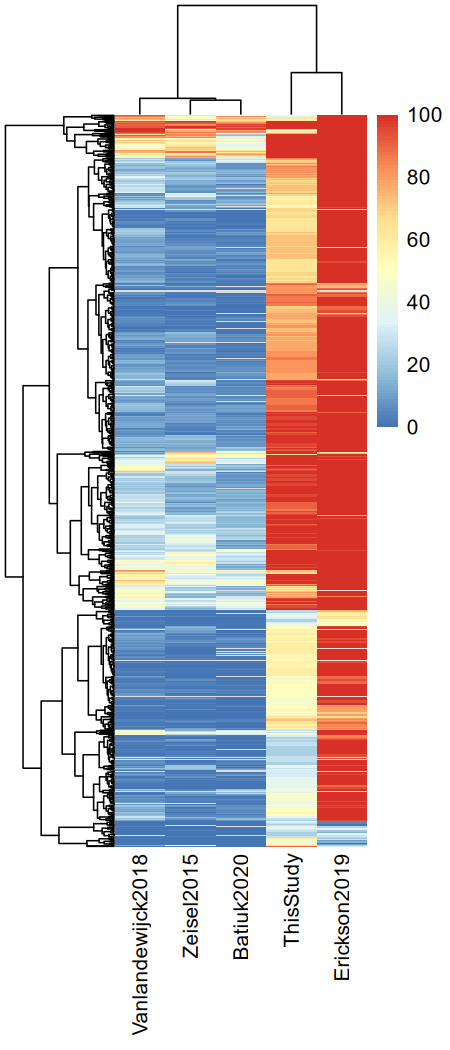

In [18]:
options(repr.plot.width = 3, repr.plot.height = 7, repr.plot.res = 150)
pheatmap(100 * fraccells_T_vs_S_both, show_rownames = FALSE, border = NA, angle = 90)


In [19]:
libsize_labels <- c("10k", "50k", "100k", "500k", "1m")
libsizes <- c(1e4L, 5e4L, 1e5L, 5e5L, 1e6L)
cnts_exon_downsampled <- mapply(
    function(k, s) {
        message(k, " ", s)
        X <- apply(cnts_exon, 2, function(x) {
            n <- sum(x)
            p <- x / n
            rmultinom(n = 1, size = s, prob = p)
        })
        rownames(X) <- rownames(cnts_exon)
        X
    }, 
    k = libsize_labels,
    s = libsizes,
    SIMPLIFY = FALSE
)

10k 10000
50k 50000
100k 100000
500k 500000
1m 1000000


In [20]:
pairwise_eset_exon_T_vs_S_downsampled <- NULL
for (libsize_label in libsize_labels) {
    message(libsize_label)
    X <- cnts_exon_downsampled[[libsize_label]]
    Y <- DESeqDataSetFromMatrix(countData = X, colData = SampleInfo, design = ~ Type)
    Y$Type <- relevel(Y$Type, ref = "N")
    Y <- estimateSizeFactors(Y)
    Z <- DESeq(Y)
    pairwise_eset_exon_T_vs_S_downsampled[[libsize_label]] <- NULL
    pairwise_eset_exon_T_vs_S_downsampled[[libsize_label]] <- results(Z, contrast = c("Type", "T", "S"))
}

10k
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
50k
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
100k
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
500k
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
1m
using pre-existing size factors
estimating dispersions
gene-wise dis

In [21]:
logfc_th <- 1
padj_th <- 0.05
pairwise_siggenes_exon_T_vs_S_downsampled <- lapply(pairwise_eset_exon_T_vs_S_downsampled, function(X) {
    Y <- as.data.frame(X)
    Y <- data.table(Symbol = rownames(X), Y)
    Y[abs(log2FoldChange) >= logfc_th & padj < padj_th, Symbol]
})

In [22]:
pairwise_siggenes_exon_T_vs_S_downsampled_sens <- sapply(pairwise_siggenes_exon_T_vs_S_downsampled, function(x) mean(pairwise_siggenes_exon$T_vs_S$both %in% x))
pairwise_siggenes_exon_T_vs_S_downsampled_spec <- sapply(pairwise_siggenes_exon_T_vs_S_downsampled, function(x) mean(x %in% pairwise_siggenes_exon$T_vs_S$both))

### Fig. S3C

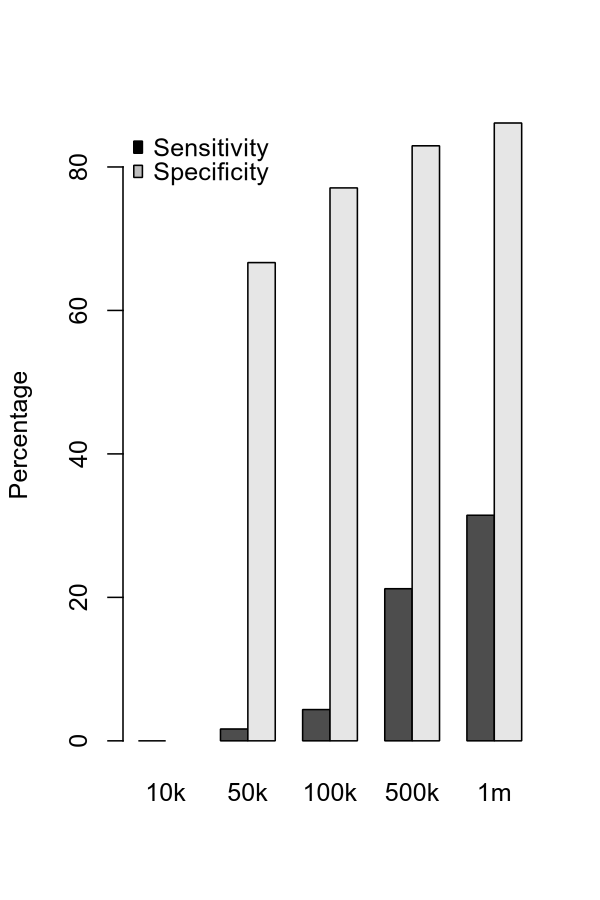

In [23]:
options(repr.plot.width = 4, repr.plot.height = 6, repr.plot.res = 150)
par(ps = 12,  bty = "l", lend = 2, ljoin = 2)
barplot(rbind(pairwise_siggenes_exon_T_vs_S_downsampled_sens * 100, pairwise_siggenes_exon_T_vs_S_downsampled_spec * 100), beside = TRUE, ylab =  "Percentage")
legend("topleft", legend = c("Sensitivity", "Specificity"), fill = c("black", "grey"), box.col = NA)

In [24]:
sampleIDs_T_S <- c(SampleInfo[Type == "S", SampleID], SampleInfo[Type == "T", SampleID])

In [25]:
cnts_exon_downsampled_10k <- cnts_exon_downsampled[["10k"]]
eset_exon_downsampled_10k <- DESeqDataSetFromMatrix(countData = cnts_exon_downsampled_10k, colData = SampleInfo, design = ~ IsResponsive)
eset_exon_downsampled_10k <- estimateSizeFactors(eset_exon_downsampled_10k)
exprs_exon_downsampled_10k <- log2(1 + counts(eset_exon_downsampled_10k, normalized = TRUE))

In [26]:
exprs_exon_dt <- fread("Result/exprs_exon.csv.gz")
exprs_exon <- as.matrix(exprs_exon_dt[, -1])
rownames(exprs_exon) <- exprs_exon_dt[[1]]

In [27]:
original <- exprs_exon[pairwise_siggenes_exon$T_vs_S$both, sampleIDs_T_S]
downsampled <- exprs_exon_downsampled_10k[pairwise_siggenes_exon$T_vs_S$both, sampleIDs_T_S]

### Fig. S3D (left)

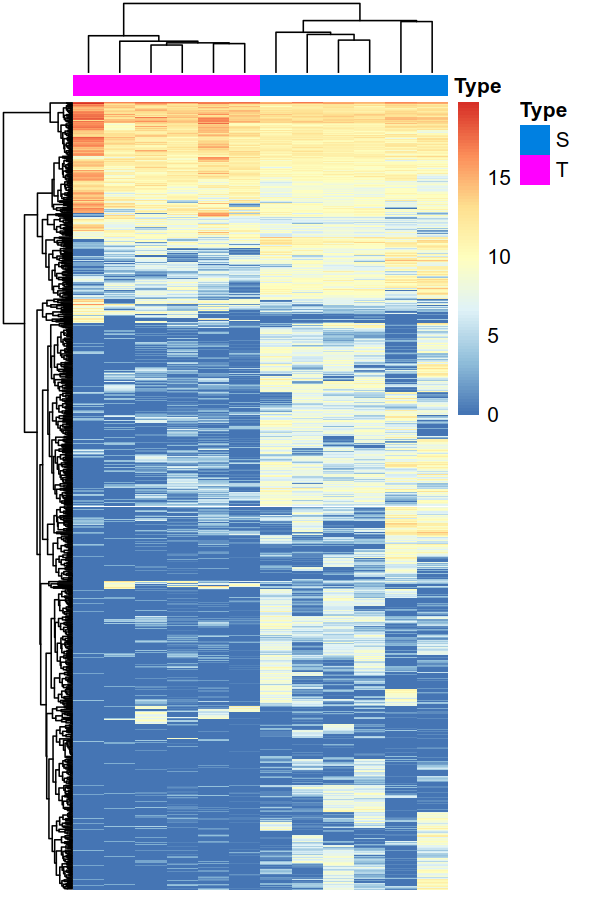

In [28]:
options(repr.plot.width = 4, repr.plot.height = 6, repr.plot.res = 150)
pheatmap(original, 
    annotation_col = SampleInfo[J(sampleIDs_T_S), data.frame(Type, row.names = SampleID), on = "SampleID"], 
    annotation_colors = list(Type = groupColors[c("S", "T")]), 
    show_rownames = FALSE, 
    show_colnames = FALSE, 
    treeheight_row = 30, 
    treeheight_col = 30
)

### Fig. S3D (right)

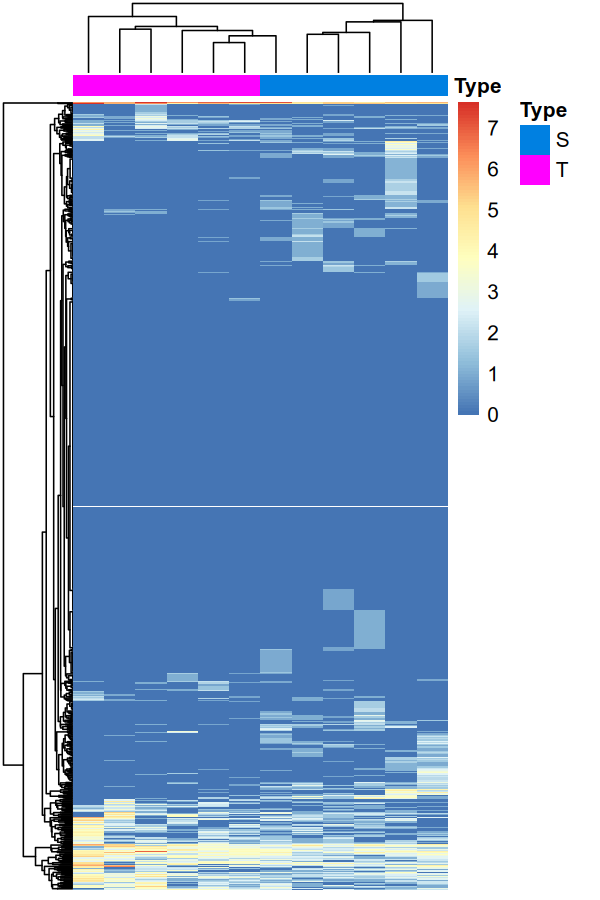

In [29]:
options(repr.plot.width = 4, repr.plot.height = 6, repr.plot.res = 150)
pheatmap(
    downsampled, 
    cluster_cols = rotate(
        hclust(dist(t(downsampled))), 
        order = sampleIDs_T_S[order(SampleInfo[J(sampleIDs_T_S), Type, on = "SampleID"], decreasing = TRUE)][c(1:6, 10:12, 9, 7:8)] # manual adjudstment to the tree order
    ), 
    annotation_col = SampleInfo[J(sampleIDs_T_S), data.frame(Type, row.names = SampleID), on = "SampleID"], 
    annotation_colors = list(Type = groupColors[c("S", "T")]), 
    show_rownames = FALSE, 
    show_colnames = FALSE, 
    treeheight_row = 30, 
    treeheight_col = 30
)

In [30]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dendextend_1.17.1           DESeq2_1.44.0              
 [3] SummarizedExperiment_1.34.0 Biobase_2.64.0             
 [5] MatrixGenerics_1.16.0       matri